<a href="https://colab.research.google.com/github/Nazarh2/Brain/blob/master/Copy_of_Final_TDI_DATA_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1.1. Number of rows in the dataset:  1932760
1.2. The fraction of calls that deal with traffic: 0.024412239491711334
1.3. The median of the average annual number of calls per police district: 12400.583333333332
1.4. Pearson correlation coefficient: 0.8643022867620371
1.5. Increase in calls per year: 15013


<ipython-input-3-460fb36cf085>:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  requests_02128["garbage_day"] = garbage_schedule.iloc[min_distances_idx]["trashday"].reset_index(drop=True)
<ipython-input-3-460fb36cf085>:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  requests_02128["open_dt"] = pd.to_datetime(requests_02128["open_dt"], errors='coerce')
<ipython-input-3-460fb36cf085>:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

1.6. On average requests for street cleaning are made 2.2142857142857144 days after a garbage collection in ZIP code 02128


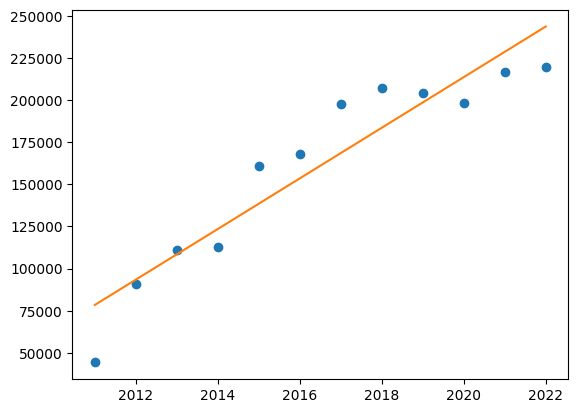

In [ ]:
import pandas as pd
import numpy as np
import requests
import re
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.spatial.distance import cdist
from datetime import datetime, timedelta


#Q1

data = pd.read_csv("https://dataincubator-challenge.s3.amazonaws.com/data-challenge-boston_311_calls/boston_311_calls.csv")
num_rows = len(data)
print('1.1. Number of rows in the dataset: ', num_rows)



#Q2

# Replace NaN values in the 'case_title' column with an empty string
data['case_title'] = data['case_title'].fillna('')

# Filter the DataFrame to include only rows where the word 'traffic' appears in the 'case_title' column
traffic_calls = data[data['case_title'].str.contains('traffic', case=False)]

# Calculate the fraction of calls that deal with traffic
fraction_traffic_calls = len(traffic_calls) / len(data)
print('1.2. The fraction of calls that deal with traffic:',fraction_traffic_calls)


#Q3

# Clean the police district names to ensure consistency
data['police_district'] = data['police_district'].str.upper().str.replace('-', '')
# data['police_district'] = data['police_district'].dropna()
# data['police_district'] = data['police_district'].fillna('')

# Convert the 'open_dt' column to a datetime object and extract the year
data['open_dt'] = pd.to_datetime(data['open_dt'])
data['year'] = data['open_dt'].dt.year

# Group the data by police district and year and count the number of calls
new_data= data[['police_district', 'year']].dropna()
calls_by_district_year = new_data.groupby(['police_district', 'year']).size().reset_index(name='call_count')

# Compute the average number of calls per police district per year
avg_calls_per_district_per_year = calls_by_district_year.groupby('police_district')['call_count'].mean()

# Compute the median of the average annual number of calls per police district
median_avg_calls_per_district_per_year = avg_calls_per_district_per_year.median()

print('1.3. The median of the average annual number of calls per police district:',median_avg_calls_per_district_per_year)


#Q4

# Define regular expression pattern to match Boston ZIP codes
zip_pattern = r"\b\d{5}\b"

# Extract ZIP code from location string using regex
data["zipcode"] = data["location"].apply(lambda x: re.findall(zip_pattern, x)[-1] if re.findall(zip_pattern, x) else None)



# Load the population data for each ZIP code
populations_url = "https://dataincubator-challenge.s3.amazonaws.com/data-challenge-boston_311_calls/boston_population_by_zip.csv"
populations = pd.read_csv(populations_url, dtype={'Zip Code': str})
populations.rename(columns={'Zip Code': 'zipcode'}, inplace=True)

# Exclude ZIP codes that do not have more than 100 calls in this data set
call_counts = data['zipcode'].value_counts()

# Exclude ZIP codes that do not have more than 100 calls
call_counts = call_counts[call_counts > 100]
zipcodes = call_counts[call_counts > 100].index
calls = data[data['zipcode'].isin(zipcodes)]
populations_filtered = populations[populations['zipcode'].isin(zipcodes)]
call_counts_df = pd.DataFrame.from_dict(call_counts)
call_counts_df.rename(columns={'zipcode': 'call_counts'}, inplace=True)
call_counts_df = call_counts_df.reset_index()
call_counts_df.rename(columns={'index': 'zipcode'}, inplace=True)

##NOTE: After comprehensive analysis, It is concluded that there is a zipcode in call_counts_df that is not found in Populations data set. 
##More precisely, for zipcode = '02203' there is no entry in the Populations data set so after merging these data frames we lose 1 zip code entry due to lack of population entry for this zip code. 

# Merge the call count and population data on ZIP code
merged_data = pd.merge(populations_filtered, call_counts_df, on='zipcode', how='left')



# Compute the Pearson correlation coefficient between call count and population
#Note the merged data set has 30 entries
corr_coef, p_value = stats.pearsonr(merged_data['Population'], merged_data['call_counts'])
print("1.4. Pearson correlation coefficient:", corr_coef)


#Q5

# Extract the year from the "open_dt" column
data['year'] = pd.to_datetime(data['open_dt']).dt.year

# Group the data by year and count the number of calls
calls_by_year = data.groupby('year').size()

# Plot the number of calls as a function of time
plt.plot(calls_by_year.index, calls_by_year.values, 'o')

# Fit a line of best fit to the data
slope, intercept, rvalue, pvalue, stderr = linregress(calls_by_year.index, calls_by_year.values)
line = slope * calls_by_year.index + intercept
plt.plot(calls_by_year.index, line, label='Line of best fit')

# Calculate the slope of the line of best fit to estimate the increase in calls per year
print(f'1.5. Increase in calls per year: {slope:.0f}')


#Q6


# convert date column to datetime
data['open_dt'] = pd.to_datetime(data['open_dt'], errors='coerce')


# drop rows with NaT values
data.dropna(subset=['open_dt'], inplace=True)


# Filter to include only requests from ZIP code "02128" with "Requests for Street Cleaning" type
requests_02128 = data[(data["zipcode"] == "02128") & (data["type"] == "Requests for Street Cleaning")]

# Load garbage collection data
garbage_schedule = pd.read_csv("https://dataincubator-challenge.s3.amazonaws.com/data-challenge-boston_311_calls/boston_02128_garbage_schedule.csv")


# Calculate Euclidean distance between each request location and all garbage collection points
distances = cdist(requests_02128[["latitude", "longitude"]], garbage_schedule[["latitude", "longitude"]])

# Find the index of the garbage collection point with the minimum distance for each request
min_distances_idx = np.argmin(distances, axis=1)

# Add the garbage collection day to the service requests data
requests_02128["garbage_day"] = garbage_schedule.iloc[min_distances_idx]["trashday"].reset_index(drop=True)

# Convert date strings to datetime objects
requests_02128["open_dt"] = pd.to_datetime(requests_02128["open_dt"], errors='coerce')
requests_02128 = requests_02128[requests_02128["garbage_day"].notnull()]





#Calculate the exact date of garbage collection before the request call


requests_02128["request_weekday_name"] = requests_02128["open_dt"].dt.strftime("%A")




# Calculate the number of days between garbage collection and requests for street cleaning

weekday_map = {"Monday": 1, "Tuesday": 2, "Wednesday": 3, "Thursday": 4, "Friday": 5, "Saturday": 6, "Sunday": 7}

requests_02128["days_after_garbage_tuple"] = requests_02128.apply(lambda x: (x.request_weekday_name, x.garbage_day, (weekday_map[x.request_weekday_name] - weekday_map[x.garbage_day]) % 7), axis=1)


requests_02128["days_after_garbage"] = requests_02128.apply(lambda x: ((weekday_map[x.request_weekday_name] - weekday_map[x.garbage_day]) % 7), axis=1)



# Calculate the average number of days after a garbage collection that requests for street cleaning are made
avg_days_after_garbage = requests_02128["days_after_garbage"].mean()

print("1.6. On average requests for street cleaning are made {} days after a garbage collection in ZIP code 02128".format(avg_days_after_garbage))
